# Model Study

### INIT

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
treeiter = TreeIter([ Tree(fn) for fn in fc.sr.NMSSM_List ])

In [3]:
for point in treeiter:
    mx=int(ak.mean(point["gen_X_m"]))
    my=int(ak.mean(point["gen_Y_m"]))
    point.sample = f"Mx{mx}_My{my}"
    if not (mx==700 and my==400): point.color = None

In [4]:
def count_all_higgs(jet_signalId):
    has_hx = (ak.any(jet_signalId == 0,axis=-1) & ak.any(jet_signalId == 1,axis=-1))
    has_h1y = (ak.any(jet_signalId == 2,axis=-1) & ak.any(jet_signalId == 3,axis=-1))
    has_h2y = (ak.any(jet_signalId == 4,axis=-1) & ak.any(jet_signalId == 5,axis=-1))

    nhiggs = 1*has_hx + 1*has_h1y + 1*has_h2y
    return nhiggs

In [5]:
treeiter.extend(kwargs=lambda tree: dict(
    nfound_nn_all_h=count_all_higgs(tree.nn_jet_signalId),
    nfound_t6_all_h=count_all_higgs(tree.t6_jet_signalId),
    nn_higgs_m_sorted=tree.nn_higgs_m[ak.argsort(tree.nn_higgs_2j_score,axis=-1)]
))

treeiter.extend(kwargs=lambda tree: dict(
    nn_6j_eff=safe_divide(tree.nfound_nn, tree.nfound_presel, default=1),
    nn_3d_eff=safe_divide(tree.nfound_nn_h, tree.nfound_nn_all_h, default=1),
    nn_2j_avg=ak.mean(tree.nn_higgs_2j_score,axis=-1),
    nn_2j_min=ak.min(tree.nn_higgs_2j_score,axis=-1),
    nn_2j_mid=np.median(tree.nn_higgs_2j_score.to_numpy(),axis=-1),
    nn_2j_max=ak.max(tree.nn_higgs_2j_score,axis=-1),
    nn_2j_min_m=tree.nn_higgs_m_sorted[:,0],
    nn_2j_mid_m=tree.nn_higgs_m_sorted[:,1],
    nn_2j_max_m=tree.nn_higgs_m_sorted[:,2],
    nn_invm0_eff=safe_divide(tree.nn_invm0, tree.gen_X_m, default=1),
    nn_invm0_diff=tree.gen_X_m-tree.nn_invm0,

    t6_eff=safe_divide(tree.nfound_t6, tree.nfound_presel, default=1),
    d_hhh_eff=safe_divide(tree.nfound_t6_h, tree.nfound_t6_all_h, default=1),
    t6_invm0_eff=safe_divide(tree.t6_invm0, tree.gen_X_m, default=1),
    t6_invm0_diff=tree.gen_X_m-tree.t6_invm0,
))


[None, None, None, None, None, None, None]

In [6]:
varinfo.nfound_presel = dict(bins=range(8),xlabel="N Presel Signal Jets")
varinfo.nfound_nn = dict(bins=range(8),xlabel="N NN6j Signal Jets")
varinfo.nfound_t6 = dict(bins=range(8),xlabel="N T6j Signal Jets")
varinfo.nn_6j_eff = dict(bins=None,xlabel="NN6j Signal Jet Eff")
varinfo.t6_eff = dict(bins=None,xlabel="T6j Signal Jet Eff")

varinfo.nfound_presel_h = dict(bins=range(5),xlabel="N Presel Higgs")
varinfo.nfound_nn_all_h = dict(bins=range(5),xlabel="N NN6j Higgs")
varinfo.nfound_nn_h = dict(bins=range(5),xlabel="N NN3d Higgs")
varinfo.nfound_t6_all_h = dict(bins=range(5),xlabel="N T6j Higgs")
varinfo.nfound_t6_h = dict(bins=range(5),xlabel="N DHHH Higgs")
varinfo.nn_3d_eff = dict(bins=None,xlabel="NN3d Higgs Eff")
varinfo.d_hhh_eff = dict(bins=None,xlabel="DHHH Signal Jet Eff")

varinfo.nn_2j_min = dict(bins=np.linspace(0,1,30),xlabel="Min NN2j Score")
varinfo.nn_2j_mid = dict(bins=np.linspace(0,1,30),xlabel="Mid NN2j Score")
varinfo.nn_2j_max = dict(bins=np.linspace(0,1,30),xlabel="Max NN2j Score")

varinfo.nn_2j_min_m = dict(bins=np.linspace(0,300,30),xlabel="Min NN2j Score Dijet Mass")
varinfo.nn_2j_mid_m = dict(bins=np.linspace(0,300,30),xlabel="Mid NN2j Score Dijet Mass")
varinfo.nn_2j_max_m = dict(bins=np.linspace(0,300,30),xlabel="Max NN2j Score Dijet Mass")

varinfo.nn_jet_pt = varinfo.jet_pt
varinfo.nn_jet_btag = varinfo.jet_btag
varinfo.nn_jet_eta = varinfo.jet_eta
varinfo.nn_jet_phi = varinfo.jet_phi

varinfo.nn_higgs_m = varinfo.higgs_m

In [7]:

def graph_signal(ydata,ylabel=None,xlabels=treeiter.sample,figax=None,set={}):
    fig,ax = graph_multi(range(7),ydatalist=[ydata[:,0]],yerrs=[ydata[:,1]],ylabel=ylabel,figax=figax)
    ax.set_xticks(list(range(7)))
    ax.set_xticklabels(xlabels,rotation=45);
    ax.set(**set)
    return fig,ax
def graph_violin(ydata,ylabel=None,xlabels=treeiter.sample,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 

    ax.violinplot(ydata)
    ax.set(xticks=list(range(1,8)),ylabel=ylabel)
    ax.set_xticklabels(xlabels,rotation=45);
    return fig,ax
def graph_boxplot(ydata,ylabel=None,xlabels=treeiter.sample,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 

    ax.boxplot(ydata)
    ax.set(xticks=list(range(1,8)),ylabel=ylabel)
    ax.set_xticklabels(xlabels,rotation=45);
    return fig,ax

## Introduction

Wanted to look into how the NNs were performing for different mass points. 

Using the the selections defined as

* Trigger: HLT\_PFHT330PT30\_QuadPFJet\_75\_60\_45\_40\_TriplePFBTagDeepCSV\_4p5
* Jets are filtered with preselection criteria
    * Jets $P_{T} > 20$ GeV
    * Jet $|\eta| < 2.5$
    * Pass Jet ID
    * Pass Jet PU ID for Jet $P_T<50$ GeV
* Require at least 6 jets to pass
* Jets are ordered in highest b-tag biased $P_{T}$
* 1st jet $P_T$>60 GeV \& tight b-tag
* 2nd jet $P_T$>40 GeV \& tight b-tag
* 3rd jet $P_T$>40 GeV \& medium b-tag
* 4th jet $P_T$>20 GeV \& medium b-tag

## Study

### Cutflow

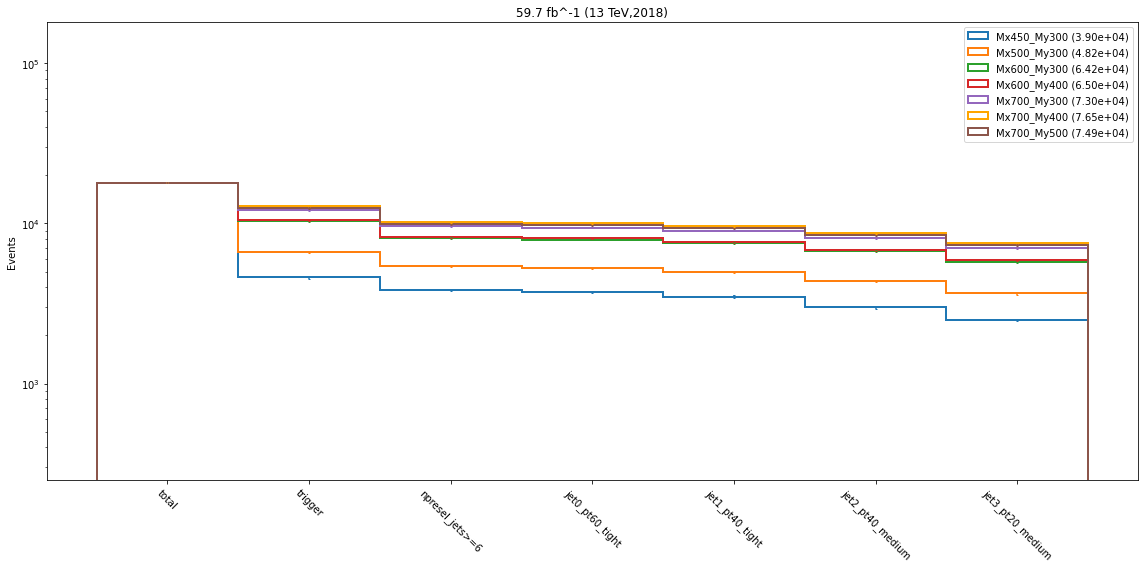

In [8]:
study.cutflow(treeiter)

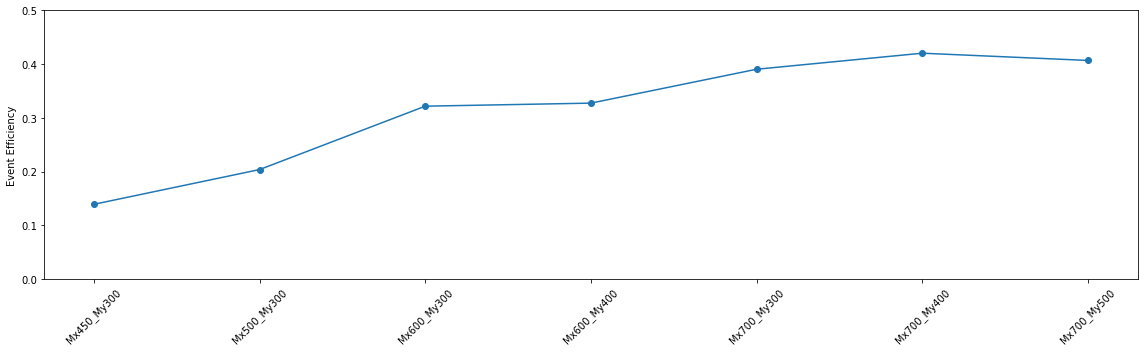

In [9]:
def event_eff(tree,ncut=-1):
    cutflow = ak.sum(tree.cutflow,axis=0)
    eff = cutflow[ncut]/cutflow[0]
    err = eff*np.sqrt(1/cutflow[ncut]+1/cutflow[0])
    return (eff,err) 

fig,axs = plt.subplots(figsize=(16,5))
sp_data = np.array([ event_eff(point) for point in treeiter ])
fig,ax = graph_signal(sp_data,ylabel="Event Efficiency",figax=(fig,axs),set=dict(ylim=(0,0.5)));
fig.tight_layout()

### Selected NN6j Jet Kinematics

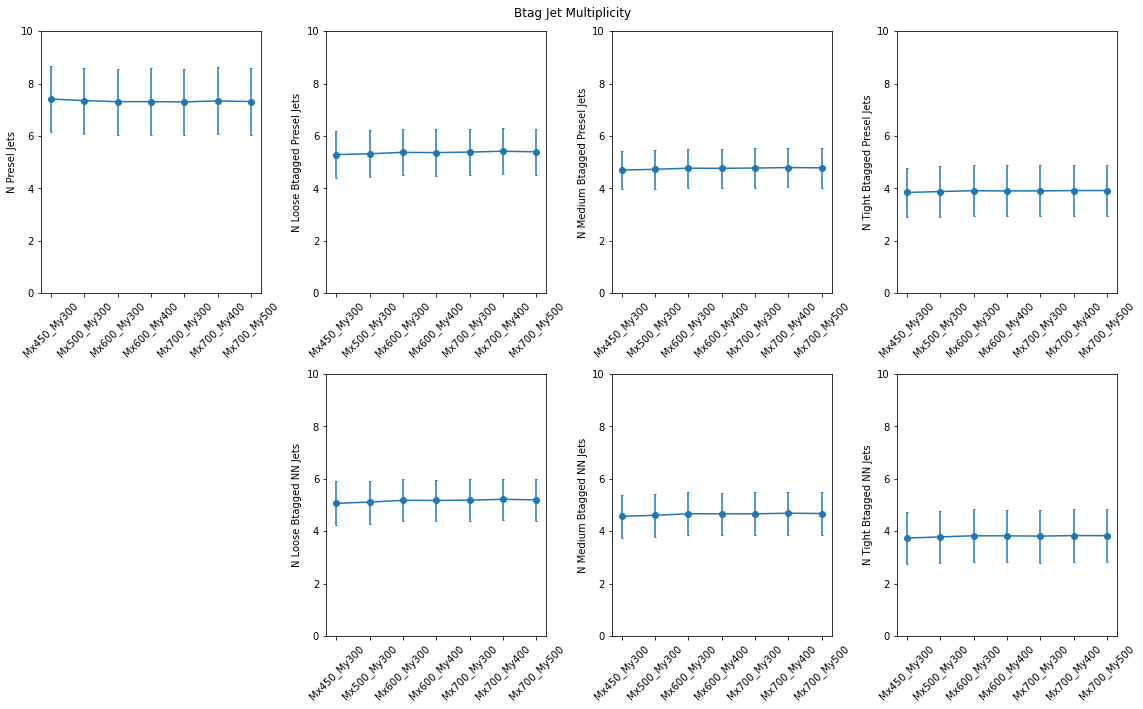

In [10]:
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(16,10))
    
graph_avgstd(treeiter.n_jet,xlabels=treeiter.sample,ylabel="N Presel Jets",figax=(fig,axs[0,0]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nloose_btag_presel,xlabels=treeiter.sample,ylabel="N Loose Btagged Presel Jets",figax=(fig,axs[0,1]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nmedium_btag_presel,xlabels=treeiter.sample,ylabel="N Medium Btagged Presel Jets",figax=(fig,axs[0,2]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.ntight_btag_presel,xlabels=treeiter.sample,ylabel="N Tight Btagged Presel Jets",figax=(fig,axs[0,3]),set=dict(ylim=(0,10)));

axs[1,0].set_visible(False)
graph_avgstd(treeiter.nloose_btag_nn,xlabels=treeiter.sample,ylabel="N Loose Btagged NN Jets",figax=(fig,axs[1,1]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nmedium_btag_nn,xlabels=treeiter.sample,ylabel="N Medium Btagged NN Jets",figax=(fig,axs[1,2]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.ntight_btag_nn,xlabels=treeiter.sample,ylabel="N Tight Btagged NN Jets",figax=(fig,axs[1,3]),set=dict(ylim=(0,10)));

fig.suptitle("Btag Jet Multiplicity")
fig.tight_layout()

In [11]:
varinfo.nn_jet_pt = dict(bins=np.linspace(0,600,30),xlabel="Jet Pt")

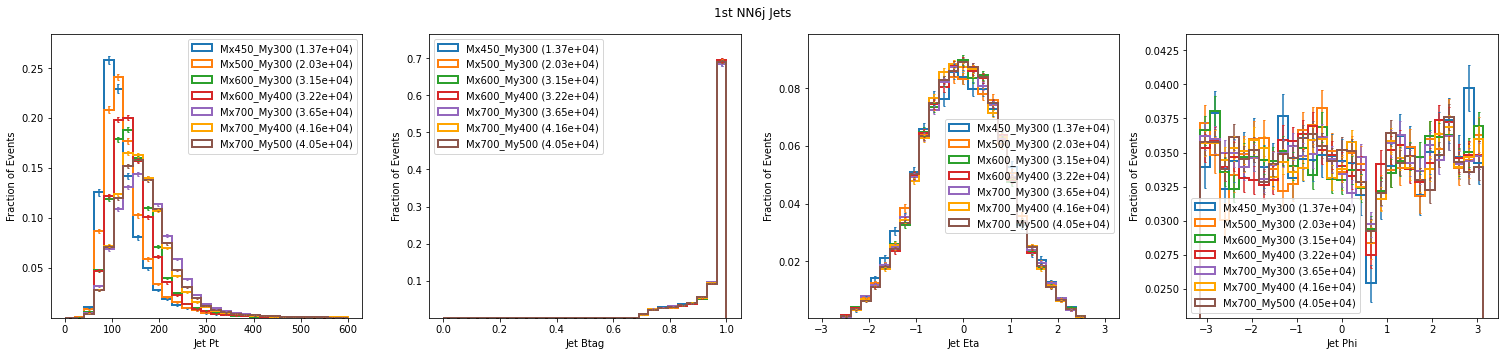

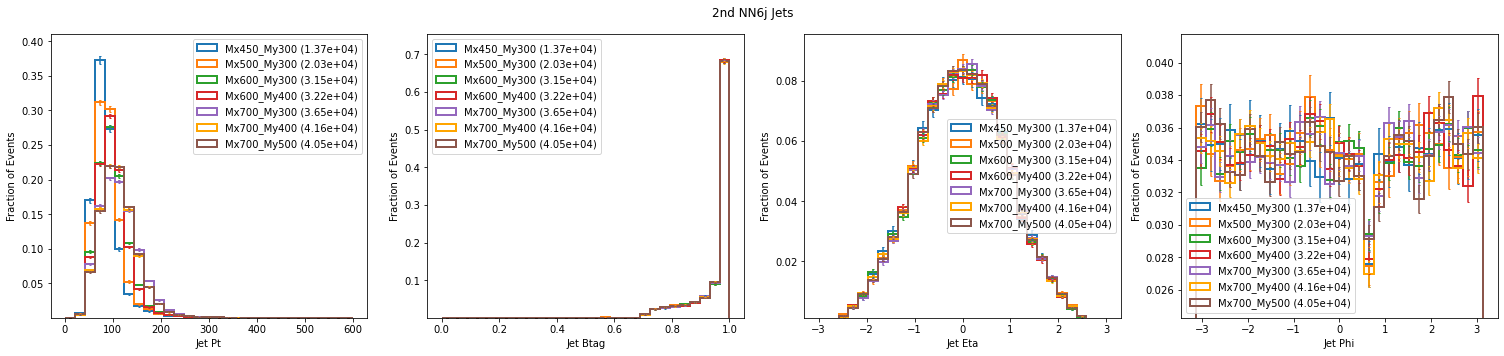

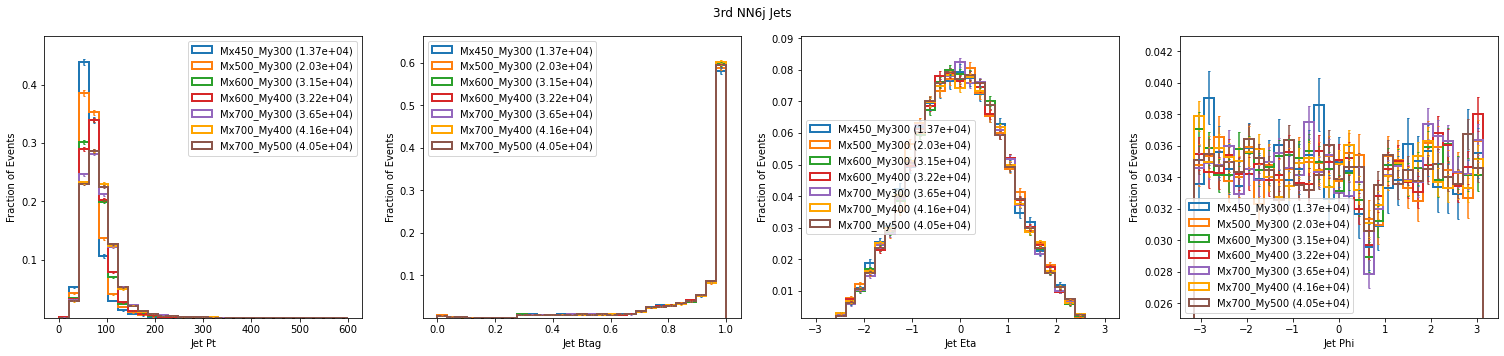

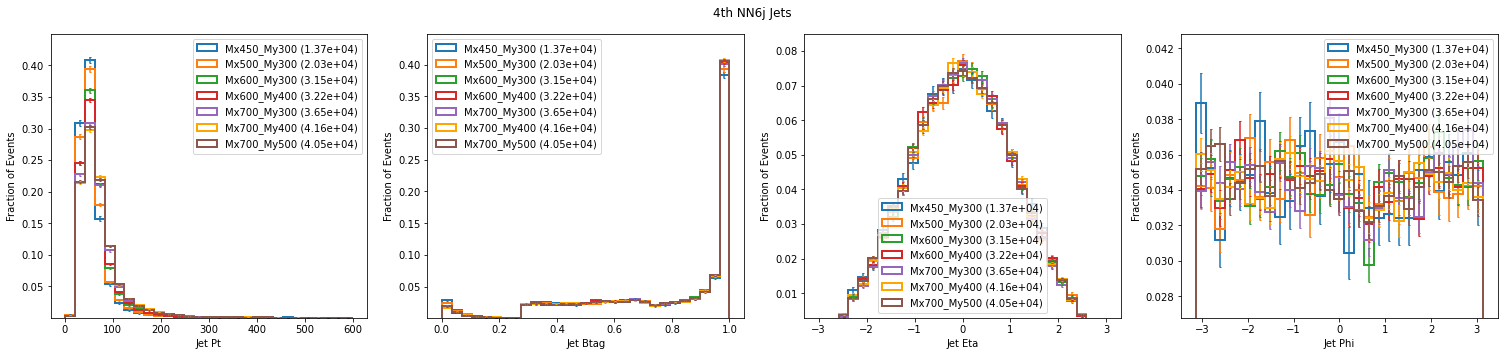

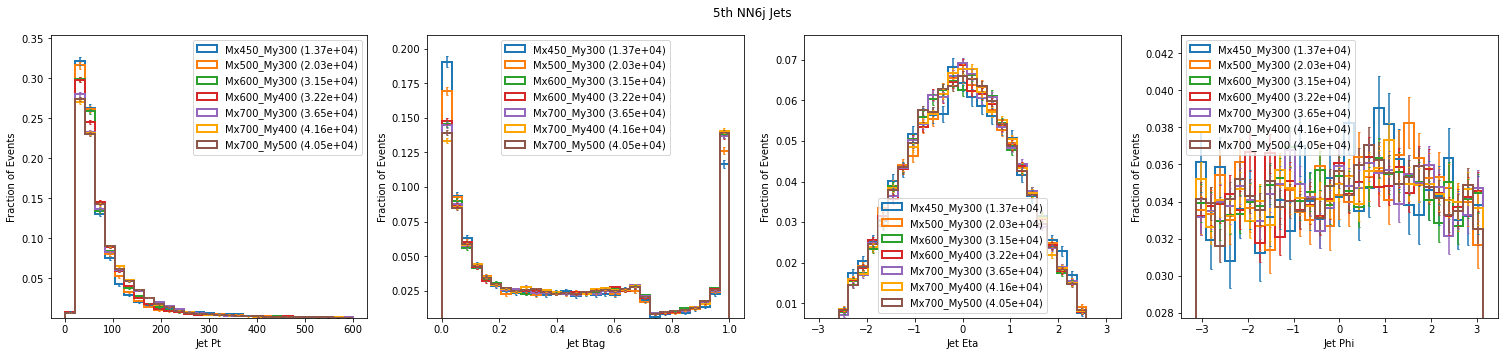

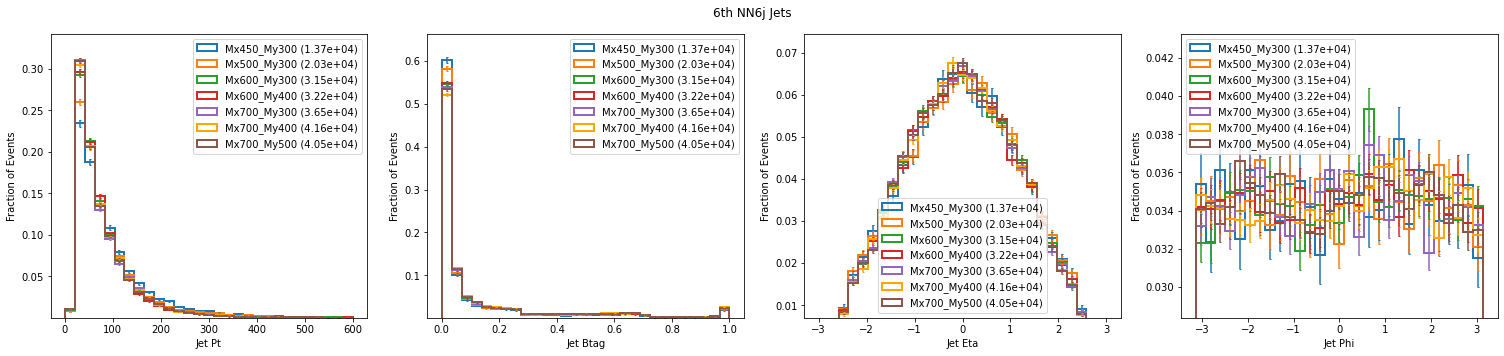

In [12]:
for i in range(6):
    study.quick(treeiter,varlist=[f"nn_jet_pt:{i}",f"nn_jet_btag:{i}",f"nn_jet_eta:{i}",f"nn_jet_phi:{i}"],title=f"{ordinal(i+1)} NN6j Jets",dim=(1,4),scale=False,density=1)

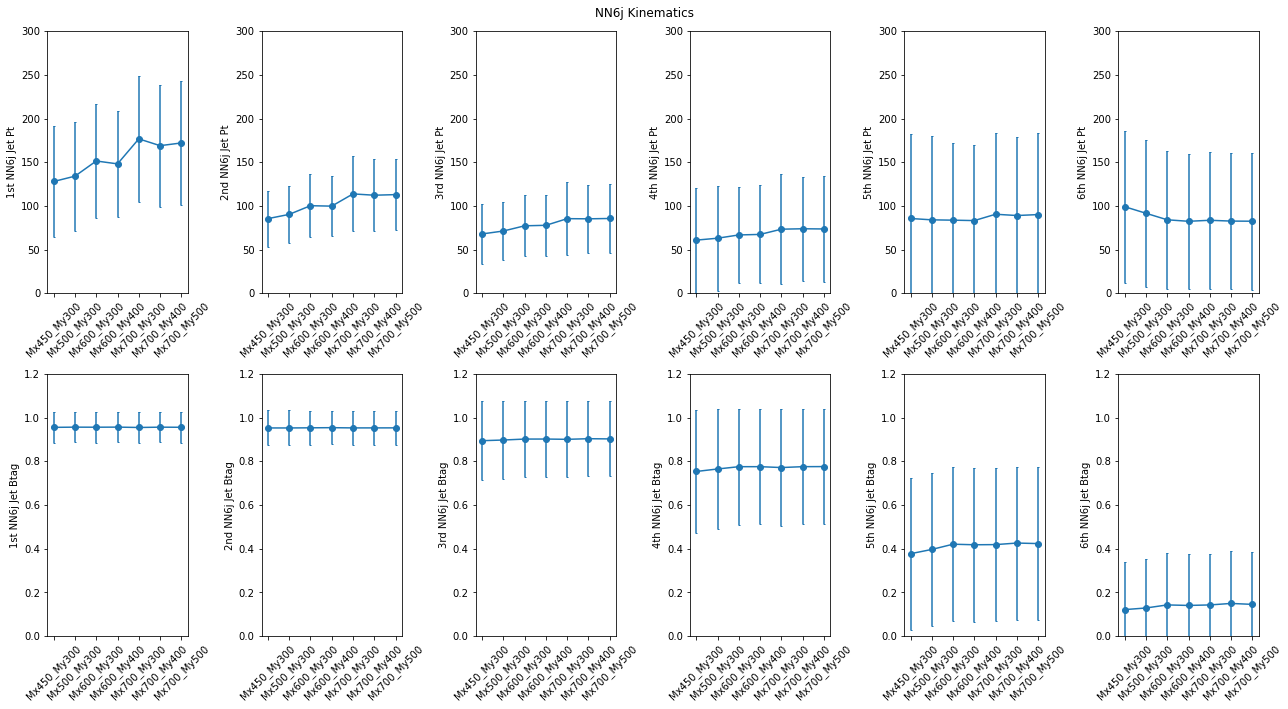

In [13]:
fig,axs = plt.subplots(nrows=2,ncols=6,figsize=(18,10))
    
for i in range(6):
    graph_avgstd([ pt[:,i] for pt in treeiter.nn_jet_pt ],ylabel=f"{ordinal(i+1)} NN6j Jet Pt",xlabels=treeiter.sample,figax=(fig,axs[0,i]),set=dict(ylim=(0,300)))
    graph_avgstd([ btag[:,i] for btag in treeiter.nn_jet_btag ],ylabel=f"{ordinal(i+1)} NN6j Jet Btag",xlabels=treeiter.sample,figax=(fig,axs[1,i]),set=dict(ylim=(0,1.2)))

fig.suptitle("NN6j Kinematics")
fig.tight_layout()

### NN Performance

#### NN6j

We are using two neural networks (NN) in this analysis.

The first NN, the 6 Jet Classifier (NN6j), assigns a score to each combination of 6 jets based on kinematics and btag. The 6 jets with the highest score are selected and then fed into the second NN, the 2 Jet Classifier (NN2j). 

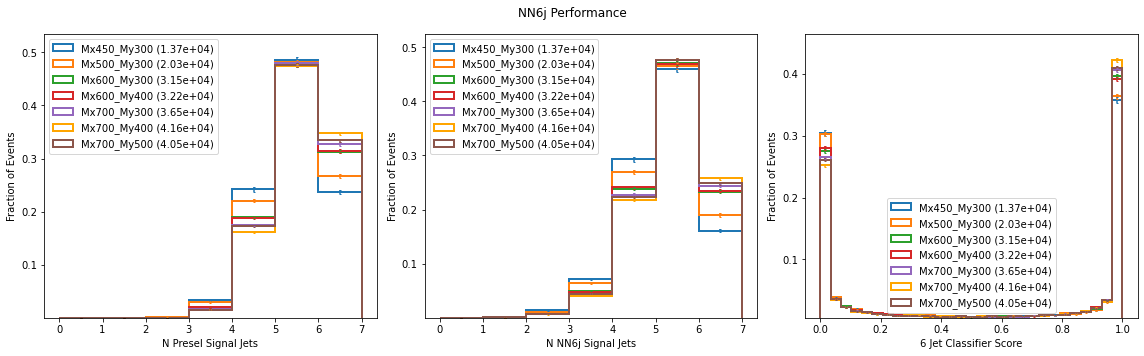

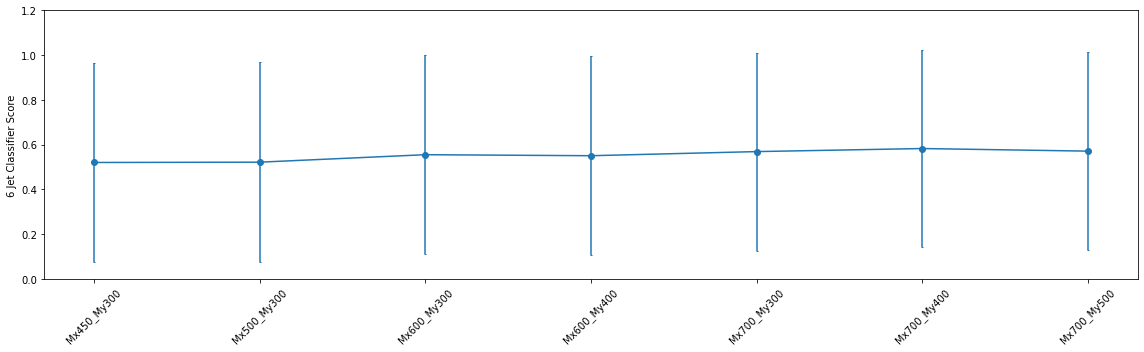

In [14]:
study.quick(treeiter, varlist=["nfound_presel", "nfound_nn","b_6j_score"],title="NN6j Performance", dim=(1, 3), density=1,scale=False)

fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
graph_avgstd(treeiter.b_6j_score,xlabels=treeiter.sample,ylabel="6 Jet Classifier Score",figax=(fig,axs),set=dict(ylim=(0,1.2)))
fig.tight_layout()

The average NN6j score across different mass points isn't changing. Which means that we are selecting similar looking events in terms of the NN6j.

We can look at another indicator of performance by considering how well the NN6j replicate the true number of signal jet that it should find.  

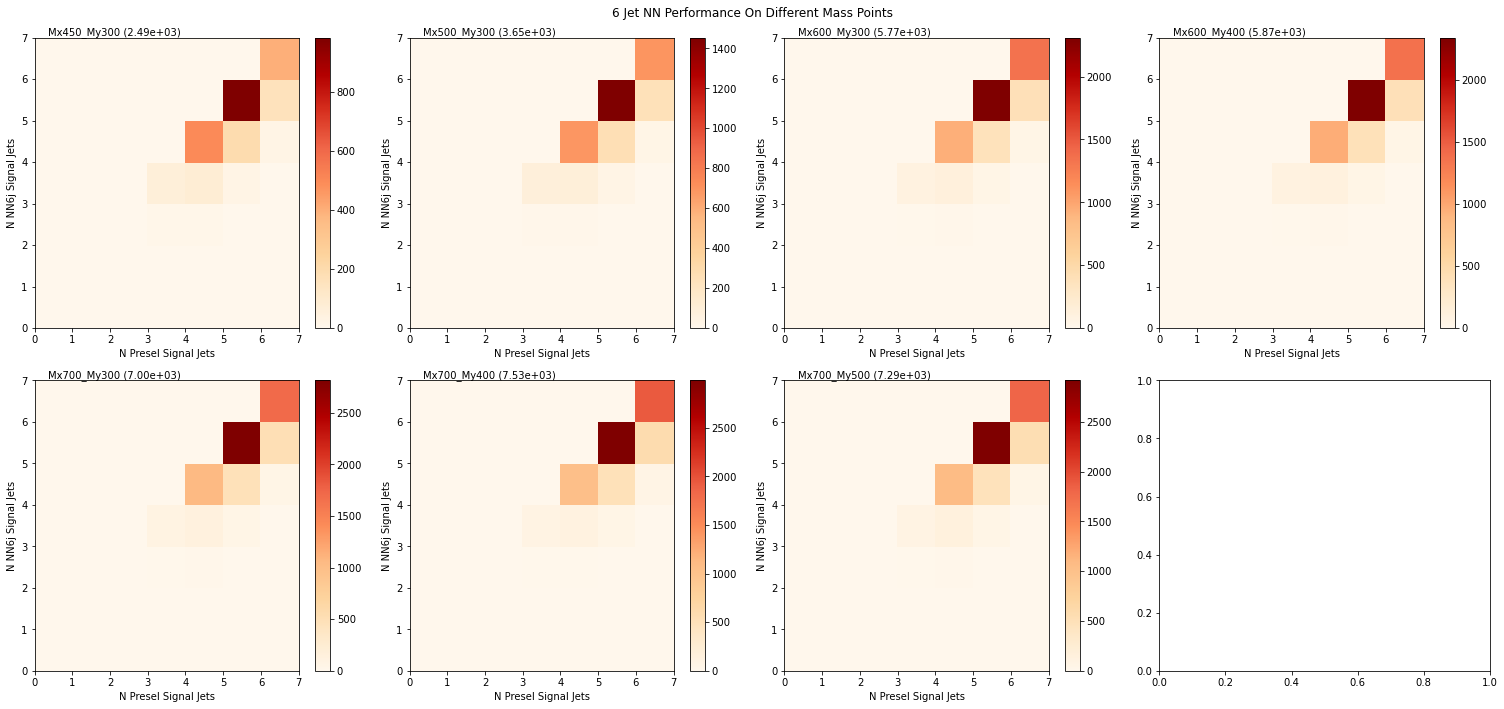

In [15]:
study.quick2d(treeiter,varlist=["nfound_presel","nfound_nn"],dim=(2,4),cmap='OrRd',title="6 Jet NN Performance On Different Mass Points",scale=False)

We can also define an efficiency for the NN6j as 

$$ E_{f} = N_{found}/N_{actual} $$ 

Looking at this efficiency, we can see that for the NN6j is doing very well at selecting all available signal jets across all mass points

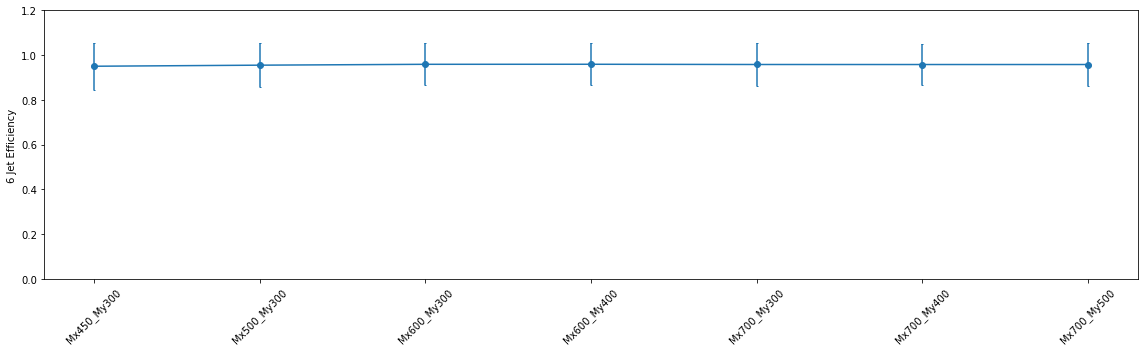

In [16]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
    
graph_avgstd(treeiter.nn_6j_eff,ylabel="6 Jet Efficiency",xlabels=treeiter.sample,figax=(fig,axs),set=dict(ylim=(0,1.2)));

fig.tight_layout()

#### NN2j

After the NN6j selects the 6 jets we use the 2 Jet Classifier (NN2j) to correctly pair them to reconstruct the 3 higgs in the event.

With 6 jets, there are 15 different ways to pair them into dijets ( nCr(6,2) ). The NN2j then uses kinematic variables to assign a score to all 15 possible pairings. 

We then need to select 3 of these pairings to reconstruct the 3 higgs in the event. There turns out only to be 15 different ways to select 3 pairs without duplicate. 

We assign a score to each of these groupings ( groups of 3 dijets ), by taking the normalized 2-norm ($\sqrt{\frac{s_1^2+s_2^2+s_3^2}{3}}$) of the 3 scores. The grouping with the highest score is then choosen. 

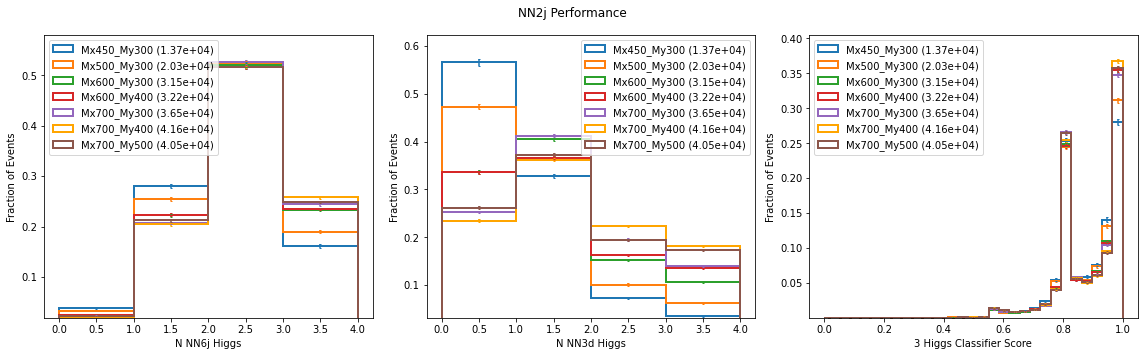

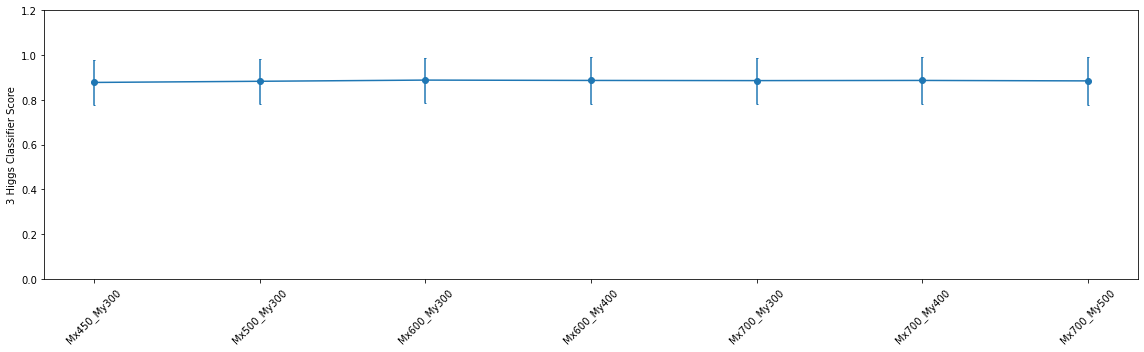

In [17]:
study.quick(treeiter,varlist=["nfound_nn_all_h", "nfound_nn_h","b_3d_score"],title="NN2j Performance",dim=(1,3),density=1,scale=False)
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
graph_avgstd(treeiter.b_3d_score,xlabels=treeiter.sample,ylabel="3 Higgs Classifier Score",figax=(fig,axs),set=dict(ylim=(0,1.2)))
fig.tight_layout()

The average NN2j score across different mass points isn't changing. However, we can see that jets are not being correctly paired when they are present.

Investigating the individual scores for the 3 dijets selected, ordered by score

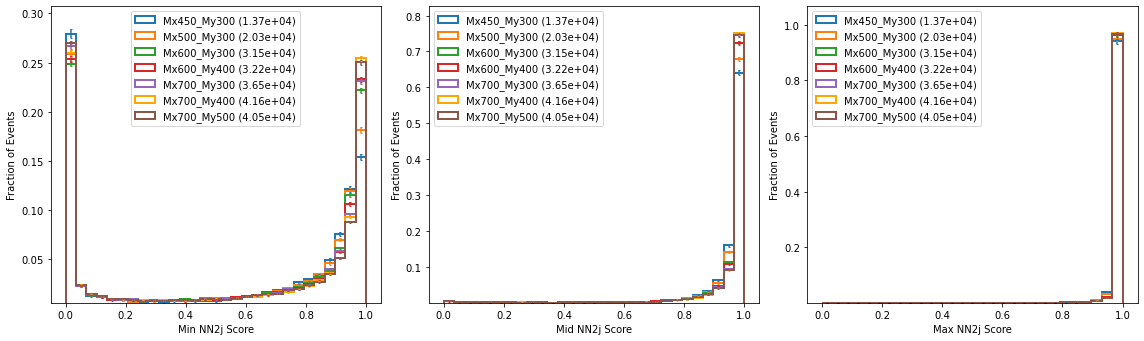

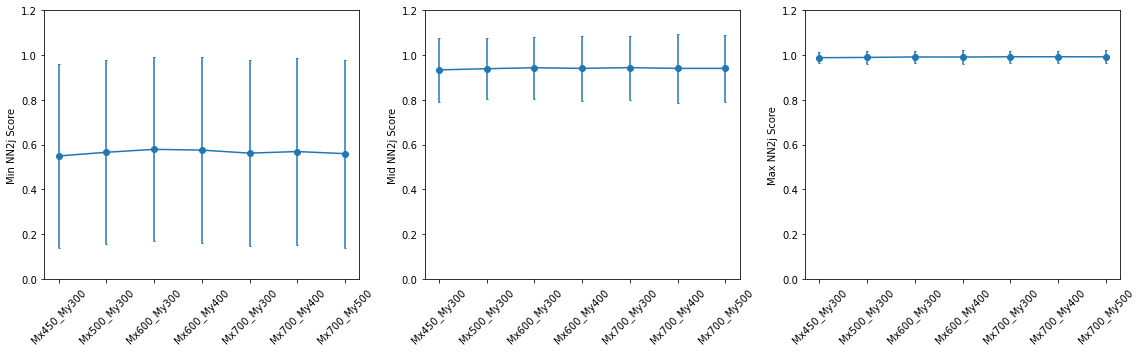

In [18]:
study.quick(treeiter,varlist=["nn_2j_min","nn_2j_mid","nn_2j_max"],dim=(1,3),scale=False,density=1)

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))

graph_avgstd(treeiter.nn_2j_min,xlabels=treeiter.sample,ylabel="Min NN2j Score",figax=(fig,axs[0]),set=dict(ylim=(0,1.2)))
graph_avgstd(treeiter.nn_2j_mid,xlabels=treeiter.sample,ylabel="Mid NN2j Score",figax=(fig,axs[1]),set=dict(ylim=(0,1.2)))
graph_avgstd(treeiter.nn_2j_max,xlabels=treeiter.sample,ylabel="Max NN2j Score",figax=(fig,axs[2]),set=dict(ylim=(0,1.2)))

fig.tight_layout()

There seems to be some difference in score for lower X mass, but this difference doesn't show up in the average. 

Investigating the higgs mass doesn't seem to tell where this difference is coming from either.

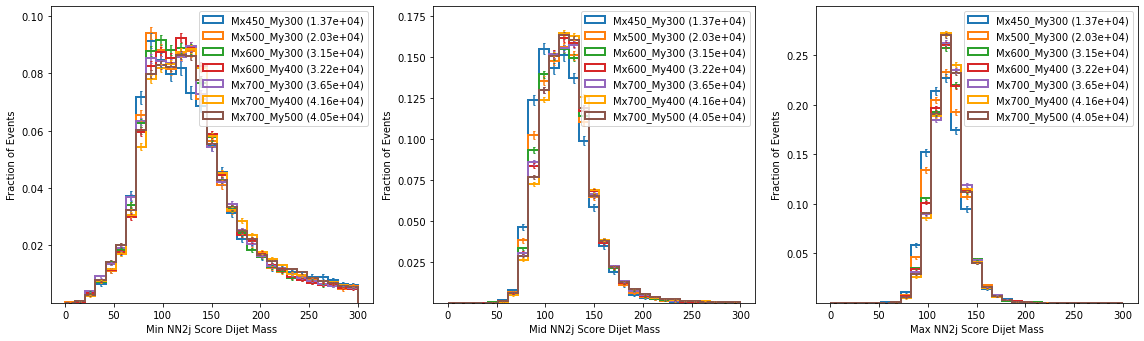

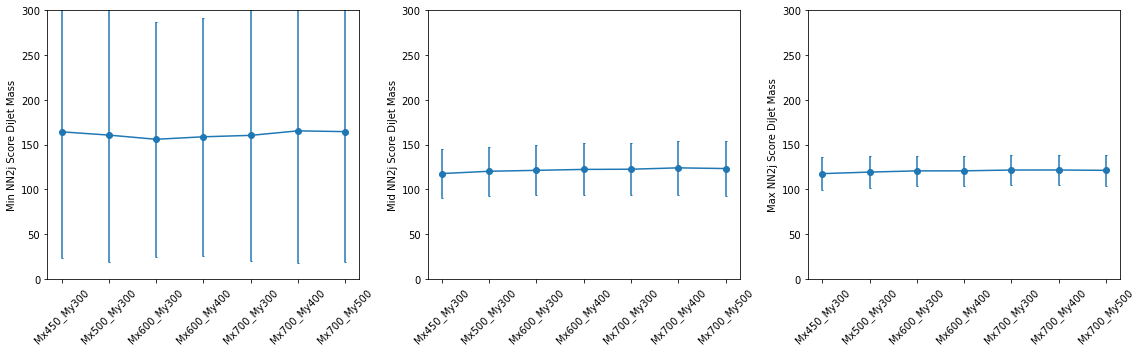

In [19]:
study.quick(treeiter,varlist=["nn_2j_min_m","nn_2j_mid_m","nn_2j_max_m"],dim=(1,3),scale=False,density=1)

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))

graph_avgstd(treeiter.nn_2j_min_m,xlabels=treeiter.sample,ylabel="Min NN2j Score DiJet Mass",figax=(fig,axs[0]),set=dict(ylim=(0,300)))
graph_avgstd(treeiter.nn_2j_mid_m,xlabels=treeiter.sample,ylabel="Mid NN2j Score DiJet Mass",figax=(fig,axs[1]),set=dict(ylim=(0,300)))
graph_avgstd(treeiter.nn_2j_max_m,xlabels=treeiter.sample,ylabel="Max NN2j Score DiJet Mass",figax=(fig,axs[2]),set=dict(ylim=(0,300)))

fig.tight_layout()

Looking at the 2D plot of the number of correctly paired higgs found by the NN2j vs how many it should find, shows this difference in performance at lower X mass

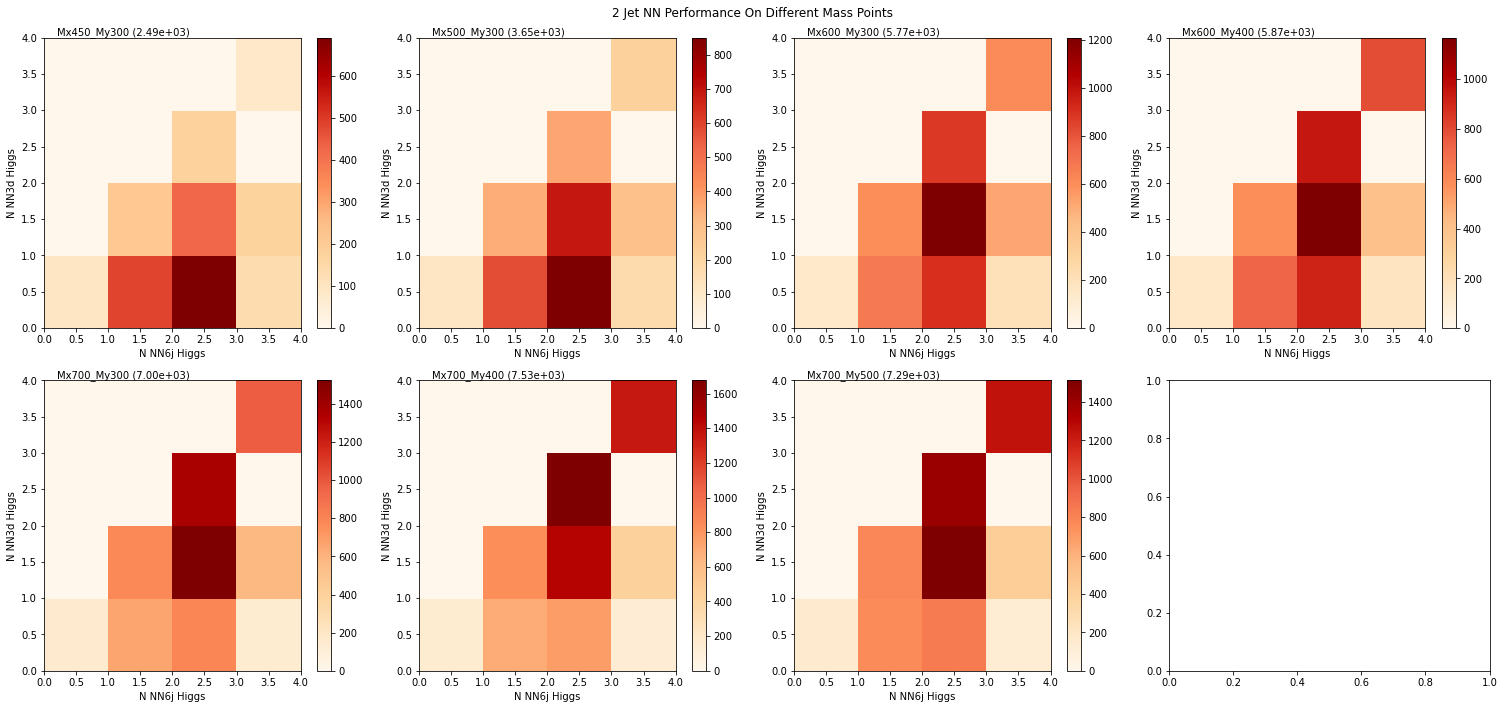

In [20]:
study.quick2d(treeiter,varlist=["nfound_nn_all_h","nfound_nn_h"],dim=(2,4),cmap='OrRd',title="2 Jet NN Performance On Different Mass Points",scale=False)

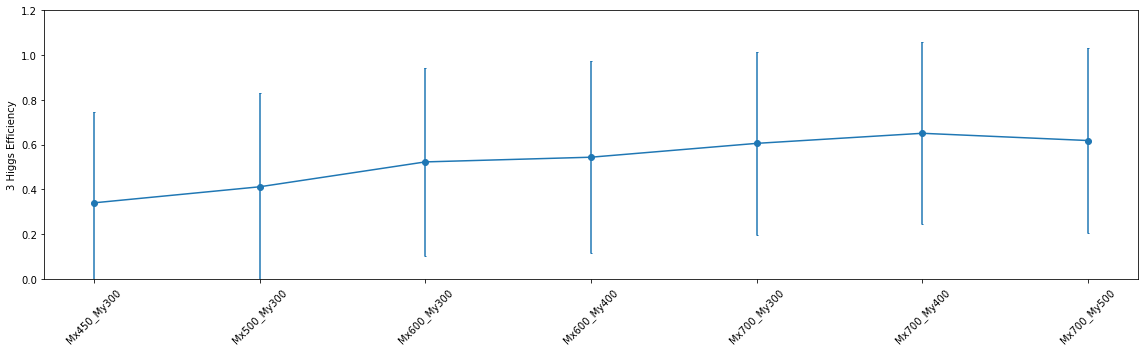

In [21]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
graph_avgstd(treeiter.nn_3d_eff,ylabel="3 Higgs Efficiency",xlabels=treeiter.sample,figax=(fig,axs),set=dict(ylim=(0,1.2)));

fig.tight_layout()

The scores shown were the highest scoring pairings in each event. 

We can also look at how the NN2j performs at pairing events where all 6 signal jets were selected by the NN6j.

In [22]:
sixbiter = EventFilter("sixb",nfound_nn=6).filter(treeiter)

In [23]:
model_2j = Model("/uscms_data/d3/ekoenig/6BAnalysis/CMSSW_10_2_18/src/sixB/analysis/sixBanalysis/models/2jet_classifier")
triH_list = [ nn2j.process(tree,model_2j,'nn_jet') for tree in sixbiter ]
truH_list = [ data[data.nhiggs==3] for data in triH_list ]

100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


AttributeError: no field named 'scores'

(https://github.com/scikit-hep/awkward-1.0/blob/1.4.0/src/awkward/highlevel.py#L1127)

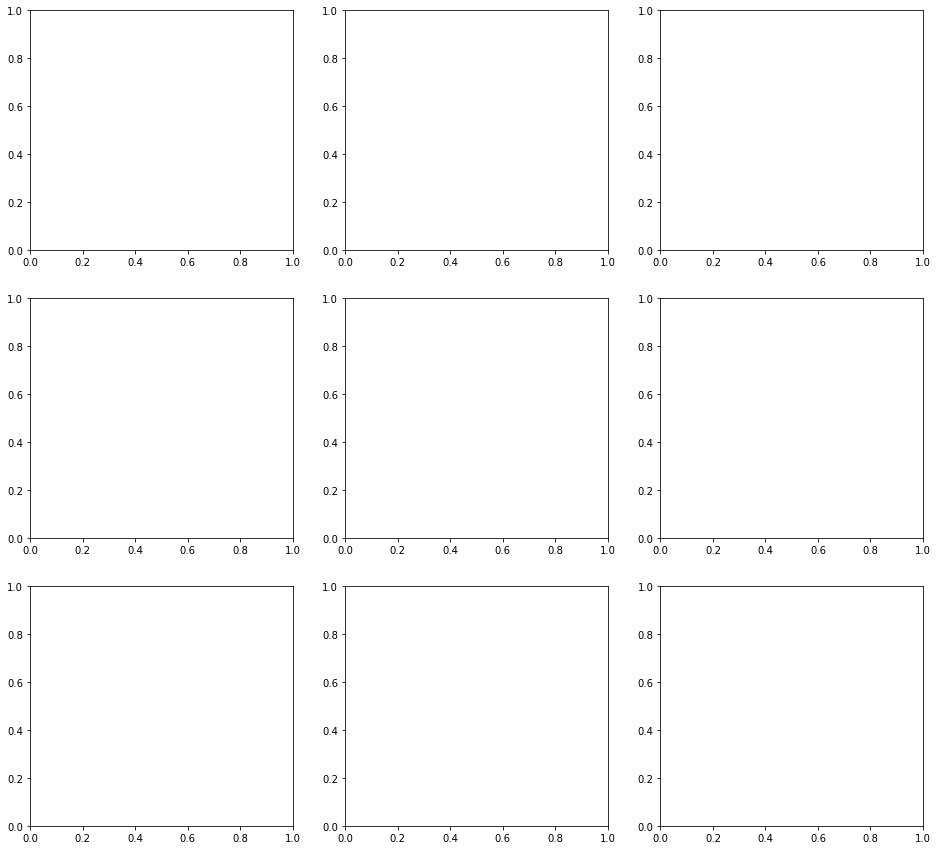

In [24]:
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(16,15))

varlist = ['min score','mid score','max score']
for i,var in enumerate(varlist):
    datalist = [ data.scores[:,i] for data in truH_list ]
    hist_multi(datalist,labels=sixbiter.sample,xlabel=var,density=1,lumikey=None,figax=(fig,axs[0,i]),bins=np.linspace(0,1,30))
    graph_avgstd(datalist,xlabels=sixbiter.sample,ylabel=var,figax=(fig,axs[1,i]),set=dict(ylim=(0,1.2)))

norm_score = [ ak.sum(data.scores**2/3,axis=-1) for data in truH_list ]
graph_avgstd(norm_score,xlabels=treeiter.sample,ylabel="3 Higgs Score",set=dict(ylim=(0,1.2)),figax=(fig,axs[2,1]))
fig.tight_layout()

axs[2,0].set_visible(False)
axs[2,2].set_visible(False)

We can see that the NN2j starts to perform differently for the lowest scoring dijet.